### EMPLOYEE ATTRITION CONTROL

#### CASE STUDY
The project is to help a company which is trying to control attrition. There are two sets of data: "Existing employees" and "Employees who have left". 

Following attributes are available for every employee;

- Satisfaction Level
- Last evaluation
- Number of projects
- Average monthly hours
- Time spent at the company
- Whether they have had a work accident
- Whether they have had a promotion in the last 5 years
- Departments (column sales)
- Salary

Use your analytics skills to answer the following questions :
1. What type of employees are leaving?
2. Which employees are prone to leave next.
3. Recommendations

In [1]:
# Load Libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("Paired", 10)
import warnings
warnings.filterwarnings('ignore')

# Load Machine Learning Packages

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



#### Load Dataset

In [2]:
# Read multiple sheets from same excel workbook, where
# sheet indexed 1 is 'Existing employee' data; and
# sheet indexed 2 is 'Employees who have left' data 

existing = pd.read_excel(r"C:\Users\hp\OneDrive\1. UTIVA- Data Science\Python\Capstone Project\Employee_Attrition.xlsx", sheet_name=1)
left = pd.read_excel(r"C:\Users\hp\OneDrive\1. UTIVA- Data Science\Python\Capstone Project\Employee_Attrition.xlsx", sheet_name=2)

In [3]:
# Create a label to identify each employee category

existing['attrition'] = 0
left['attrition'] = 1

Our problem statements involves predictng employees who are prone to leave, hence the binary classification of employees who have left is set as [1], which represents true in a booleen classification. 

In [4]:
# Join the dataframes together along rows
employees = pd.concat([existing, left], axis = 0)

In [5]:
# Randomise the dataset
empoyees= employees.sample(frac=1, ignore_index = True)

It is important to randomise the dataset because from the concatenation step taken, we have the existing employees data in the top rows, and that of employees who have left at the bottom rows. Randomising our data will help our model to learn the general patterns in the data, rather than memorizing the specific order of the data.

#### Data Cleaning

In [6]:
# Check data information
employees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14999 entries, 0 to 3570
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Emp ID                 14999 non-null  float64
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  float64
 4   average_montly_hours   14999 non-null  float64
 5   time_spend_company     14999 non-null  float64
 6   Work_accident          14999 non-null  float64
 7   promotion_last_5years  14999 non-null  float64
 8   dept                   14999 non-null  object 
 9   salary                 14999 non-null  object 
 10  attrition              14999 non-null  int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 1.4+ MB


From the above we can see that there are no missing values in our dataset.

In [7]:
# Check descriptive information about dataset
round(employees.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Emp ID,14999.0,7500.00,4329.98,1.00,3750.50,7500.00,11249.50,14999.0
satisfaction_level,14999.0,0.61,0.25,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.72,0.17,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.80,1.23,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.05,49.94,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.50,1.46,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.14,0.35,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.02,0.14,0.00,0.00,0.00,0.00,1.0
attrition,14999.0,0.24,0.43,0.00,0.00,0.00,0.00,1.0


In [8]:
# Drop employees ID column to avoid overfitting
employees.drop('Emp ID', axis = 1, inplace = True)
employees.head(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary,attrition
0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,sales,low,0
1,0.82,0.67,2.0,202.0,3.0,0.0,0.0,sales,low,0


In [9]:
# Rename columns for compatibility of view
employees.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'dept', 'salary', 'attrition'],
      dtype='object')

In [10]:
employees.rename({'satisfaction_level': 'satisfaction', 'last_evaluation':'evaluation', 'number_project': 'project',
       'average_montly_hours': 'hours', 'time_spend_company': 'tenure', 'Work_accident': 'accident',
       'promotion_last_5years': 'promotion'}, inplace = True, axis = 1)

employees.head(2)

,satisfaction,evaluation,project,hours,tenure,accident,promotion,dept,salary,attrition
0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,sales,low,0
1,0.82,0.67,2.0,202.0,3.0,0.0,0.0,sales,low,0


In [11]:
# check for duplicate
employees.duplicated().sum()

3008

In [12]:
# Drop the duplicates in the dataset
employees.drop_duplicates(inplace= True)

### Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Employee Distribution by Attrition')

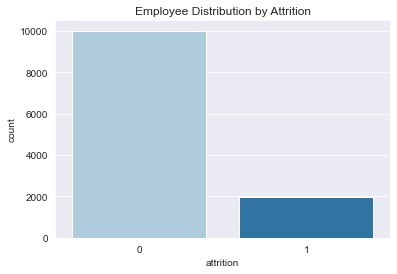

In [13]:
# plot the categorical distribution of employees by attrition
sns.countplot(x='attrition', data= employees)
plt.title('Employee Distribution by Attrition')

From the above plot, we can see there is an imbalance in the distribution of employees by attrition. It is important that we deal with this imbalance further into our anlyses to ensure our model performs well on all classes.

Text(0.5, 1.0, 'Heatmap Correlation Plot')

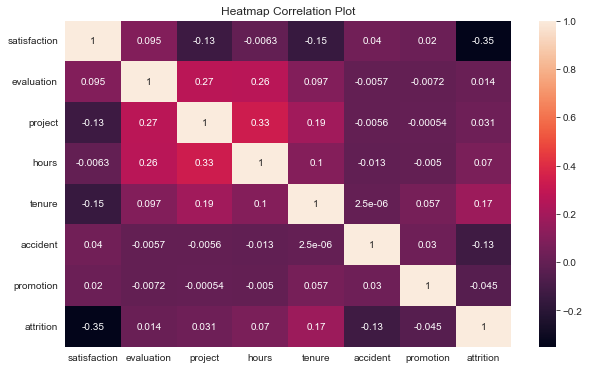

In [14]:
# plot the correlation among variables
plt.figure(figsize=(10, 6))
sns.heatmap(employees.corr(), annot= True)
plt.title('Heatmap Correlation Plot')

From the plot above, we can see that the highest negatively correlated variables are 'satisfaction' and 'attrition' at -0.35. This could be indicative of low satisfaction levels resulting in high attrition rate.

The highest positively correlated variables are 'project' and 'hours' at 0.33, which could imply that employees with high project engagements have the longest working hours monthly.

Our problem statement is concerned with knowing which kind of employees are leaving hence, we will be drilling down to analyse employees satisfaction levels.

Text(0.5, 1.0, 'Distribution of Employees by Satisfaction Level')

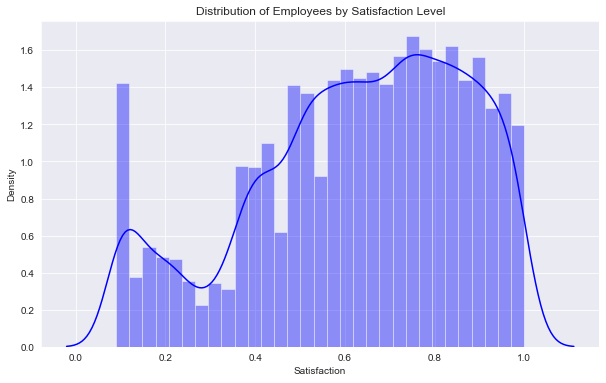

In [15]:
# distribution of "satisfaction" level
plt.figure(figsize= (10, 6))
sns.distplot(x= employees['satisfaction'] , kde= True, color= 'b', axlabel= "Satisfaction")
plt.title('Distribution of Employees by Satisfaction Level')

From the above, we can see the plot is not normally distributed. There are more employees at higher stisfaction levels than there are at lower satisfaction levels. Next, we will subset the data to observe the kind of employees within lower satisfaction levels.

In [16]:
# subset data based on satisfaction level using 0.4 as the benchmark
unsatisfied= employees[employees['satisfaction'] <= 0.4]
satisfied= employees[employees['satisfaction'] > 0.4]

Now categorize employees in each subset based on attrition

Text(0.5, 1.0, 'Count of Employees Satisfaction by Attrition')

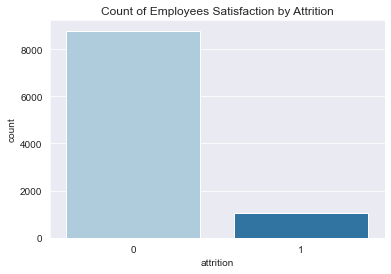

In [17]:
# Check the count of satisfied employees per attrition category
sns.countplot(x= 'attrition', data= satisfied)
plt.title('Count of Employees Satisfaction by Attrition')

Text(0.5, 1.0, 'Count of Employees Disatisfaction by Attrition')

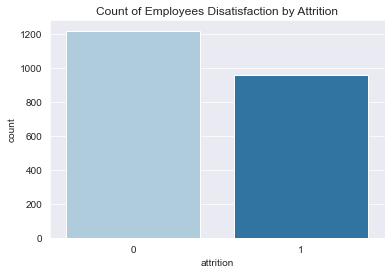

In [18]:
# Check the count of unsatisfied employees per attrition category
sns.countplot(x= 'attrition', data= unsatisfied)
plt.title('Count of Employees Disatisfaction by Attrition')

From the above plots, we can see that at less than or equal to 0.4 satisfaction levels, more employees are likely to leave than they are at above 0.4 staisfaction levels. This could imply that employees with lower satisfaction levels are likely to exit the company. However, we need to further analyse the unsatisfied employees range.

<AxesSubplot:xlabel='attrition', ylabel='satisfaction'>

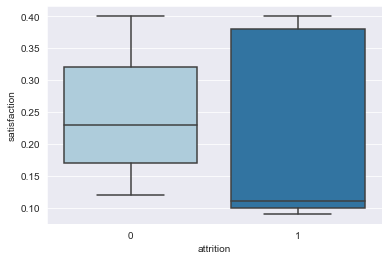

In [19]:
# categorical plot of unsatisfied employees subset
sns.boxplot(x='attrition', y= 'satisfaction', data= unsatisfied)

From the above, we see that 50% of the unsatisfied employees are at or below 0.12 satisfaction levels. Now we will check the count of employee attrition using 0.12 as the benchmark.

Text(0.5, 1.0, 'Count of Satisfied Employees by Attrition (>0.12)')

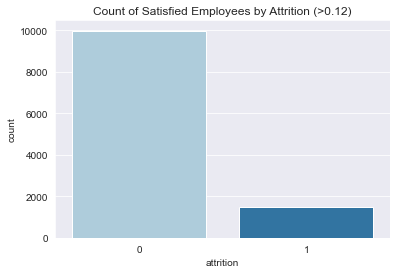

In [20]:
# count of satisfied employees above 0.12
satisfied_emp = employees[employees['satisfaction'] > 0.12]
sns.countplot(x= 'attrition', data= satisfied_emp)
plt.title('Count of Satisfied Employees by Attrition (>0.12)')


Text(0.5, 1.0, 'Count of Unsatisfied Employees by Attrition (<=0.12)')

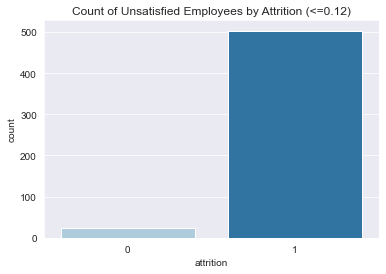

In [21]:
# count of unsatisfied employees at or below 0.12
unsatisfied_emp = employees[employees['satisfaction'] <= 0.12]
unsatisfied_emp_count= sns.countplot(x= 'attrition', data= unsatisfied_emp)
plt.title('Count of Unsatisfied Employees by Attrition (<=0.12)')

From the above plot we see that all employees with satisfaction levels at 0.12 or less leave the organisation, while a larger number of those with satisfaction level above 0.12 stay with the organisation.

What factors could be influencing employees disatisfaction? 

From the heatmap plot above we can see that no other numerical variable has a strong correlation with satisfaction or attrition thus, we will explore the ordinal variable 'salary' and the nominal variable 'dept'.

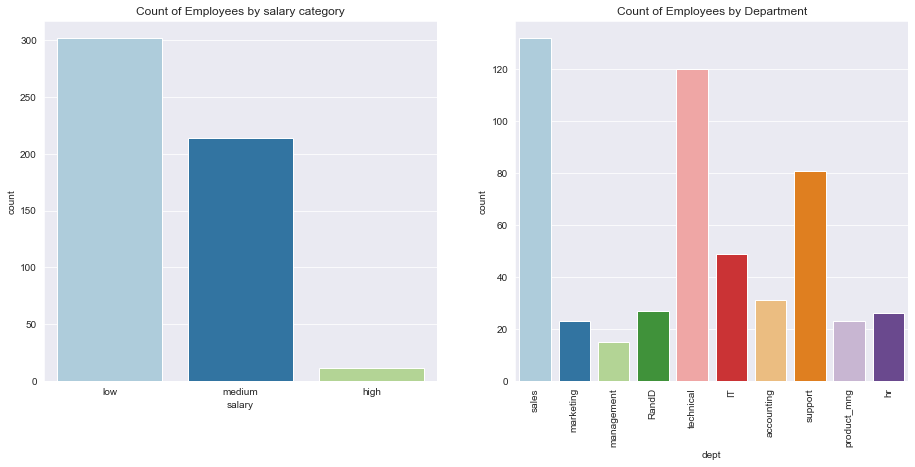

In [22]:
# plot count of unsatisfied employees per salary grade
plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
sns.countplot(x='salary', data= unsatisfied_emp)
plt.title('Count of Employees by salary category')

# plot count of unsatisfied employee per department
plt.subplot(1,2,2)
sns.countplot(x='dept', data= unsatisfied_emp)
plt.title('Count of Employees by Department')
plt.xticks(rotation=90)

# set the spacing between subplot
plt.subplots_adjust(left=0.5, bottom=0.4, right=0.9,top=0.9, wspace=0.2,hspace=0.2)
plt.show()

From the above plot we see that the highest number of employees that have left are those who earn low salaries and medium salaries respectively, whereas the departments with highest attrition of unsatisfied employees are sales,techical, support, and IT departments respectively. 

##### Problem Statement 1: What type of employees are leaving?


From our analyses we can conclude that employees with low satisfaction level of 0.12 or less, who earn low or medium salaries are leaving. Furthermore, unsatisfied employees working in any of sales, technical, support, and IT departments are leaving the company.

### Data Preprocessing

###### One Hot Encoding

To handle the nominal categorical variable in our dataset namely 'dept', we will perform one hot encoding which perfectly helps to represent the presence of categorical variables in our dataset.

In [23]:
# Examine the categorical data
print("Department:", employees['dept'].unique())

Department: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'RandD' 'marketing']


In [24]:
# create a copy of dataset to preserve the original dataset
employees_copy= employees.copy()
employees_copy.head(2)

,satisfaction,evaluation,project,hours,tenure,accident,promotion,dept,salary,attrition
0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,sales,low,0
1,0.82,0.67,2.0,202.0,3.0,0.0,0.0,sales,low,0


In [25]:
# encode the categorical variable
employees_copy_enc= pd.get_dummies(employees_copy, columns= ['dept'], drop_first= True )
employees_copy_enc.head(2)

,satisfaction,evaluation,project,hours,tenure,accident,promotion,salary,attrition,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,low,0,0,0,0,0,0,0,1,0,0
1,0.82,0.67,2.0,202.0,3.0,0.0,0.0,low,0,0,0,0,0,0,0,1,0,0


###### Label Encoding

The use of label encoding is more appropirate for ordinal categorical data like the 'salary' in our dataset. 

In [26]:
# load the labelencoder objecg
le= preprocessing.LabelEncoder()

In [27]:
employees_copy_enc['salary'] = le.fit_transform(employees_copy_enc['salary'])

Label enconding has a limitation of arbitrarily assigning weights to the binary values of the variables. We have to ensure that the weight assigned are representative of our data sequential order.

In [28]:
# check the count of attributes in the salary column
employees_copy['salary'].value_counts()

low       5740
medium    5261
high       990
Name: salary, dtype: int64

In [29]:
# check how label encoding has assigned index to the values
employees_copy_enc['salary'].value_counts()

1    5740
2    5261
0     990
Name: salary, dtype: int64

In [30]:
# Rework the assigned values to give weights with appropriate priorty ranking
# high = 0, medium = 1, and low = 2
employees_copy_enc['salary']= employees_copy_enc['salary'].apply(lambda x :[1,2,0].index(x))

In [31]:
employees_copy_enc['salary'].value_counts()

0    5740
1    5261
2     990
Name: salary, dtype: int64

In [32]:
# view dataset
employees_copy_enc.head(2)

,satisfaction,evaluation,project,hours,tenure,accident,promotion,salary,attrition,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0
1,0.82,0.67,2.0,202.0,3.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0


###### Handling imbalanced data

As noted above, we have to handle the imbalance in our dataset before training our model to ensure our model performs well without bias to the majority class. We will be using the SMOTE method of oversampling to handle the imbalance.

In [33]:
# Counting the distribution of the bean grains in each class
class_counts = employees_copy_enc['attrition'].value_counts()

# Print the class counts
print(class_counts)

0    10000
1     1991
Name: attrition, dtype: int64


In [34]:
# Declare our independent and dependent variables
x =  employees_copy_enc.drop('attrition', axis= 1).values
y = employees_copy_enc['attrition'].values

In [35]:
# create the SMOTE object
sm = SMOTE(random_state= 7)

In [36]:
# Resample the dataset
x_resampled, y_resampled = sm.fit_resample(x, y)

In [37]:
# Counting the number of instances in each class after resampling
print('Attrition Class distribution after resampling:')
print(pd.Series(y_resampled).value_counts())

Attrition Class distribution after resampling:
0    10000
1    10000
dtype: int64


###### Scaling Our Dataset

It is important to scale our train data to enhance the performance of our model as it ensures that no single feature dominates the distance calculations in our algorithm. We will be using the StandardScaler method.

In [38]:
# split data into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7)

In [39]:
# Declare the Standard scaler object
sc = StandardScaler()

In [40]:
# Preprocessing the features
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

### Data Modeling

In [41]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_train_scaled, y_train, test_size= 0.2, random_state =20)

In [42]:
# Create empty lists

models = []
results = []
names = []

scoring = 'roc_auc'

# append algorithm and names to list

models.append(('RF', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('GB', GaussianNB()))
models.append(('SVM', SVC()))

# Iterate over algorithm

for name, model in models:
    kfold = KFold(n_splits=10, random_state= 7, shuffle=True)
    cv_score =  cross_val_score(model, x_train, y_train, scoring=scoring, cv=kfold)
    results.append(cv_score)
    names.append(name)
    
    print(f"{name}: {cv_score.mean()}, {cv_score.std()}")

RF: 0.997353115640163, 0.0012479276884164946
DT: 0.9773624698690405, 0.0049507926930604665
LR: 0.8472859926565821, 0.01286377371814091
GB: 0.8206785876552338, 0.020201212568346835
SVM: 0.9856290398337487, 0.003265843160111233


We will evaluate the two best performing models namely; RF and SVM respectively

###### Model Prediction and Evaluation

#### SupportVectorClassifier

In [43]:
# train the algorithim
svm = SVC()
svm.fit(x_train, y_train)
pred = svm.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1660
           1       0.95      0.95      0.95      1540

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200



In [44]:
# Confussion matrix
print(confusion_matrix(pred, y_test))

[[1585   75]
 [  70 1470]]


#### RandomForestClassifier

In [45]:
# train the algorithim
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1684
           1       0.98      0.99      0.99      1516

    accuracy                           0.99      3200
   macro avg       0.99      0.99      0.99      3200
weighted avg       0.99      0.99      0.99      3200



In [46]:
# Confussion matrix
print(confusion_matrix(pred, y_test))

[[1647   37]
 [   8 1508]]


From the above, the best performing model is RandomForestClassifier

Interpreting the result from RandomForestClassifier model


We will base our decision on how well our model is performing using our target F1 score of 0.98 because it does well with predicting the minority class.

When predicting attrition, we prefer to predict that an employee will leave and have the employee not leave than to predict they will not leave and have them leave. Hence we are more concerned about the False Positive from our confusion matrix which stands as 9.

##### Problem Statement 2: Which employees are prone to leave next?

To predict this we will be working with the existing employees data.

In [47]:
existing.head(1)

,Emp ID,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary,attrition
0,2001.0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,sales,low,0


###### Preparing the dataset for prediction

In [48]:
# Create a copy of the data and drop the attrition column 
exit_prone = existing.copy()
exit_prone.drop('attrition', axis = True, inplace= True)

In [49]:
exit_prone.head(2)

,Emp ID,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary
0,2001.0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,sales,low
1,2002.0,0.82,0.67,2.0,202.0,3.0,0.0,0.0,sales,low


In [50]:
# Rename columns
exit_prone.rename({'satisfaction_level': 'satisfaction', 'last_evaluation':'evaluation', 'number_project': 'project',
       'average_montly_hours': 'hours', 'time_spend_company': 'tenure', 'Work_accident': 'accident',
       'promotion_last_5years': 'promotion'}, inplace = True, axis = 1)

In [51]:
exit_prone.head(2)

,Emp ID,satisfaction,evaluation,project,hours,tenure,accident,promotion,dept,salary
0,2001.0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,sales,low
1,2002.0,0.82,0.67,2.0,202.0,3.0,0.0,0.0,sales,low


In [60]:
# Check for duplicates
print(exit_prone.duplicated().sum())

0


In [53]:
# Encode categorical variable

# One Hot encoding for nominal variable 'dept'
exit_prone_enc= pd.get_dummies(exit_prone, columns=['dept'], drop_first= True)
exit_prone_enc.head(2)

,Emp ID,satisfaction,evaluation,project,hours,tenure,accident,promotion,salary,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,2001.0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,low,0,0,0,0,0,0,1,0,0
1,2002.0,0.82,0.67,2.0,202.0,3.0,0.0,0.0,low,0,0,0,0,0,0,1,0,0


In [54]:
# Label encoding for ordinal variable 'salary'
exit_prone_enc['salary'] = le.fit_transform(exit_prone_enc['salary'])
exit_prone_enc['salary']= exit_prone_enc['salary'].apply(lambda x :[1,2,0].index(x))
exit_prone_enc.head(2)

,Emp ID,satisfaction,evaluation,project,hours,tenure,accident,promotion,salary,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
0,2001.0,0.58,0.74,4.0,215.0,3.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0
1,2002.0,0.82,0.67,2.0,202.0,3.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0


###### Predict Attrition

In [55]:
prediction = rf.predict(exit_prone_enc.drop('Emp ID', axis= 1))

In [56]:
exit_pred= pd.DataFrame({'Emp_ID': exit_prone['Emp ID'], 'Status': prediction})

In [59]:
# The ID of employees can be used to trace the specific employee in our predicton
print(exit_pred)

        Emp_ID  Status
0       2001.0       1
1       2002.0       0
2       2003.0       1
3       2004.0       0
4       2005.0       1
...        ...     ...
11423  14207.0       0
11424  14208.0       0
11425  14209.0       0
11426  14210.0       0
11427  14211.0       1

[11428 rows x 2 columns]


In [58]:
exit_pred['Status'].value_counts()

1    5776
0    5652
Name: Status, dtype: int64

Our model predicts that 11,295 of our existing employees are prone to leave the company. Each of them can be traced using their employee ID.

###### Recommendation

The company should review upward the salary scale of employees prone to exit to make them more satisfied with their jobs as low and medium salaries are a demotivation for the staff. Furthermore, it should examine why more employees from sales, technical, support, and IT are prone to leave as other factors such as work-life balance, targets, hostile managers etc could be influncing their satisfaction level.